In [0]:
import pandas as pd
from tqdm.notebook import tqdm_notebook
from dateutil import parser
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
from profanity_check import predict, predict_prob
import warnings
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from textblob import TextBlob
import emoji
import itertools 
import matplotlib.style as style
from google.colab import files
style.use('ggplot')
warnings.filterwarnings('ignore')

# Preprocessing

In [0]:
def valid_user(str):
  if len(str.split(' ')) < 5 and not 'left' in str and not 'added' in str and not 'removed' in str:
    return True
  elif '+91' in str and len(str.split(' ')) <= 3:
    return True
  return False

In [7]:
def vali_date(text):
    try:
        datetime.datetime.strptime(text, '%m/%d/%y')
        return True
    except Exception as e:
      return False

lines = []
with open('WhatsApp Chat with The Boys.txt') as f:
  for line in f:
    if vali_date(line.split(',')[0]):
      lines.append(line.strip('\n'))
    else:
      lines[len(lines) - 1] += ' ' + line.strip('\n')
  
datetimes, names, msgs = ([] for i in range(3))
for line in tqdm_notebook(lines, total = len(lines), unit = 'line'):
    datetimes.append(datetime.datetime.strptime(line.split('-')[0], '%m/%d/%y, %I:%M %p '))
    names.append(line.split('-')[1].split(':')[0].strip())
    msgs.append(''.join(line.split('-')[1].split(':')[1:]))

df = pd.DataFrame()
df['datetime'] = datetimes
df['name'] = names
df['msg'] = msgs

'''
The file  had lines for when the group names were changed, and when people left or were removed. 
I will remove these since they are of no use. One more friend changed his number, and to include that, 
I had to do a little bit more filtering. 
'''

def valid_user(str):
  if len(str.split(' ')) < 5 and not 'left' in str and not 'added' in str and not 'removed' in str and not 'admin' in str:
    return True
  elif '+91' in str and len(str.split(' ')) <= 3:
    return True
  return False


df = df[df['name'].apply(valid_user)]
df.loc[(df.name == '<redacted>'), 'name'] = 'MM' 
df.loc[(df.name == '<redacted>'), 'name'] = 'MM' 
df.loc[(df.name == '<redacted>'), 'name'] = 'SD' 
df.loc[(df.name == '<redacted>'), 'name'] = 'BA'
df.loc[(df.name == '<redacted>'), 'name'] = 'RF'
df.loc[(df.name == '<redacted>'), 'name'] = 'SJ'
df.loc[(df.name == '<redacted>'), 'name'] = 'GJ'
df.loc[(df.name == '<redacted>'), 'name'] = 'BD'
df.loc[(df.name == '<redacted>'), 'name'] = 'SM'
df = df[df['name'] != '<redacted>']
df['name'].unique()

df['date'] = df['datetime'].apply(lambda x: x.date())
df['day_sent'] = df['datetime'].dt.strftime('%a')
df['month_sent'] = df['datetime'].dt.strftime('%b')
df['year_sent'] = df['datetime'].dt.year
df['count'] = 1 # To groupby days and have a count of how many messages were sent per day
df = df[~df['msg'].apply(lambda x: True if '\xa0' in x else False)] # To remove characters with '\xa0'
print(df.shape)


(39176, 8)


In [8]:
def vali_date(text):
    try:
        datetime.datetime.strptime(text, '%d/%m/%y')
        return True
    except Exception as e:
      return False

lines = []
with open('Whatsapp Chat with The Boys Old.txt') as f:
  for line in f:
    if vali_date(line.split(',')[0]):
      lines.append(line.strip('\n'))
    else:
      lines[len(lines) - 1] += ' ' + line.strip('\n')
  
datetimes, names, msgs = ([] for i in range(3))
for line in tqdm_notebook(lines, total = len(lines), unit = 'line'):
    datetimes.append(datetime.datetime.strptime(line.split('-')[0], '%d/%m/%y, %I:%M %p '))
    names.append(line.split('-')[1].split(':')[0].strip())
    msgs.append(''.join(line.split('-')[1].split(':')[1:]))

df2 = pd.DataFrame()
df2['datetime'] = datetimes
df2['name'] = names
df2['msg'] = msgs


df2 = df2[df2['name'].apply(valid_user)]
df2.loc[(df2.name == '<redacted>'), 'name'] = 'MM' 
df2.loc[(df2.name == '<redacted>'), 'name'] = 'SD' 
df2.loc[(df2.name == '<redacted>'), 'name'] = 'BA'
df2.loc[(df2.name == '<redacted>'), 'name'] = 'RF'
df2.loc[(df2.name == '<redacted>'), 'name'] = 'SJ'
df2.loc[(df2.name == '<redacted>'), 'name'] = 'GJ'
df2.loc[(df2.name == '<redacted>'), 'name'] = 'BD'
df2.loc[(df2.name == '<redacted>'), 'name'] = 'SM'
df2 = df2[df2['name'] != '<redacted>']
df2['name'].unique()

df2['day_sent'] = df2['datetime'].dt.strftime('%a')
df2['month_sent'] = df2['datetime'].dt.strftime('%b')
df2['year_sent'] = df2['datetime'].dt.year
df2['date'] = df2['datetime'].apply(lambda x: x.date())
df2['count'] = 1 # To groupby days and have a count of how many messages were sent per day
df2 = df2[~df2['msg'].apply(lambda x: True if '\xa0' in x else False)] # To remove characters with '\xa0'
print(df2.shape)


(68584, 8)


In [9]:
df = pd.concat([df, df2]).drop_duplicates().reset_index(drop = True)
df = df.sort_values(by = 'datetime')
print(df.shape)
df.head()

(74357, 8)


,datetime,name,msg,date,day_sent,month_sent,year_sent,count
38363,2017-09-05 21:16:00,RF,Welcome to the new group. I'm gonna get strai...,2017-09-05,Tue,Sep,2017,1
38364,2017-09-05 21:17:00,SJ,K,2017-09-05,Tue,Sep,2017,1
38365,2017-09-05 21:25:00,SD,Hi all. Good to see you guys again.,2017-09-05,Tue,Sep,2017,1
38366,2017-09-05 21:26:00,RF,<Media omitted>,2017-09-05,Tue,Sep,2017,1
38367,2017-09-05 21:29:00,BA,"Doubt Why is a pizza circle, cut into a trian...",2017-09-05,Tue,Sep,2017,1


Text(0.5, 1.0, 'Messages sent per day over a time period')

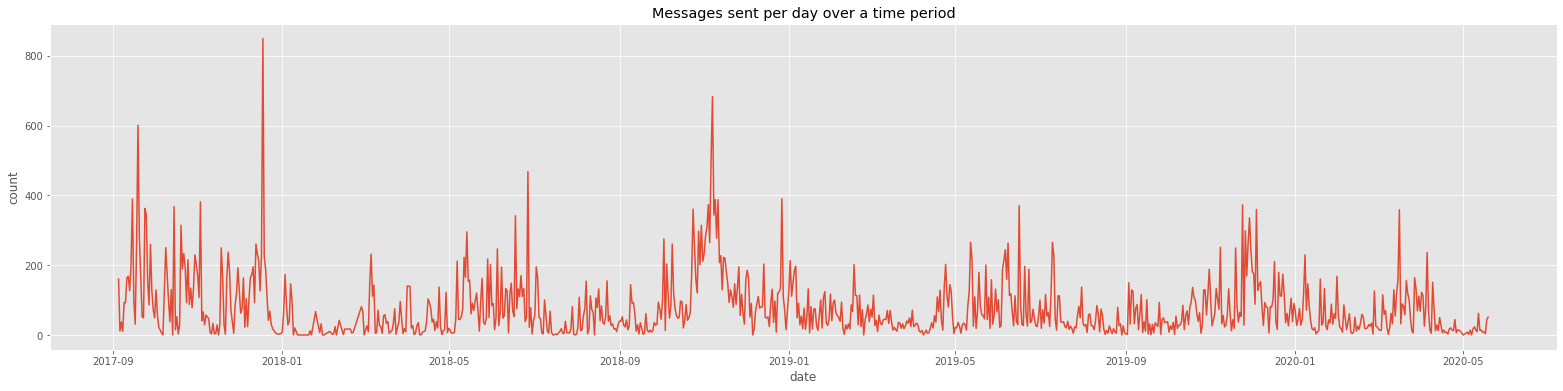

In [10]:
grouped_by_date = df.groupby('date').sum().reset_index()

plt.figure(figsize = (27, 6))
sns.lineplot(x = 'date', y = 'count', data = grouped_by_date)
plt.title('Messages sent per day over a time period')

#plt.savefig('lineplot_full.svg', format = 'svg')
#files.download('lineplot_full.svg')

# Exploratory Data Analysis

I'm defining the following function to main consistent colors for each person across all plots. Since the order will vary depending on the plot, this is passed to the function which will reorder colors in a particular order so that the color of a certain person remains the same no matter the plot. This will help maintain consistency and readability amongst the many graphs I will be plotting. 

I could've used seaborn's color palette but wanted to try some different colors so I grabbed them from https://coolors.co/


{'BA': '#F9C74F',
 'BD': '#6D597A',
 'GJ': '#43AA8B',
 'MM': '#90BE6D',
 'RF': '#F94144',
 'SD': '#F8961E',
 'SJ': '#F3722C',
 'SM': '#577590'}

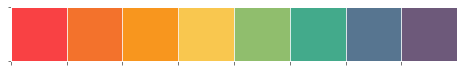

In [11]:
def get_colors_of_certain_order(names_in_certain_order):
  order = list(names_in_certain_order)
  return_list = []
  for name in order:
    return_list.append(color_dict[name])
  return return_list

color_dict = {}
colors = ['#F94144', '#F3722C', '#F8961E', '#F9C74F', '#90BE6D', '#43AA8B', '#577590', '#6D597A']
sns.palplot(colors)
names = df['name'].unique()

for name, color in zip(names, colors):
  color_dict[name] = color

color_dict

Text(0.5, 1.0, 'Average Message Lengths')

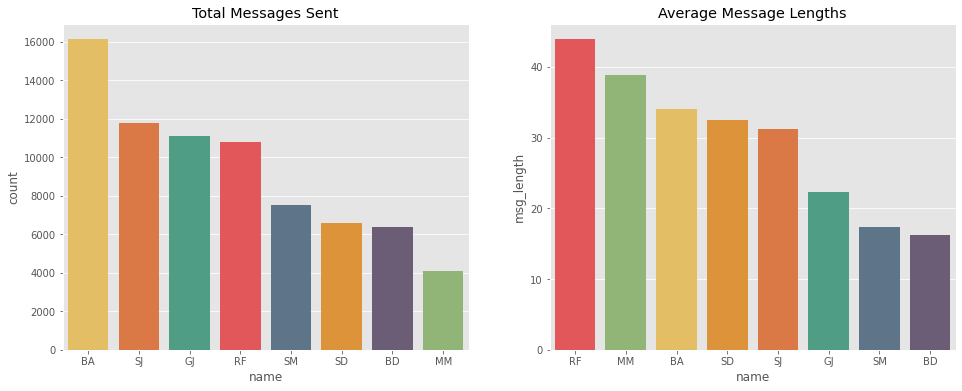

In [12]:
fig, axs = plt.subplots(ncols = 2, figsize = (16, 6))

# Plot 1 - Countplot of total messages sent
sns.countplot(x = 'name', data = df, order = df['name'].value_counts().index, ax = axs[0], palette = get_colors_of_certain_order(df['name'].value_counts().index))
axs[0].set_title('Total Messages Sent')

# Plot 2 - Barplot of average message lengths
df['msg_length'] = df['msg'].apply(lambda x: len(x))
avg_msg_lengths = df.groupby('name').mean().reset_index().sort_values(by = 'msg_length', ascending = False)
sns.barplot(x = 'name', y = 'msg_length', data = avg_msg_lengths, ax = axs[1], palette = get_colors_of_certain_order(avg_msg_lengths['name']))
axs[1].set_title('Average Message Lengths')

#plt.savefig('msg_plots.svg', format = 'svg')
#files.download('msg_plots.svg')

In [13]:
df[df['name'] == 'RF'].sort_values(by = 'msg_length', ascending = False).head(4)

,datetime,name,msg,date,day_sent,month_sent,year_sent,count,msg_length
51922,2017-12-18 17:33:00,RF,BASIS BASIS BASIS BASIS BASIS BASIS BASIS BAS...,2017-12-18,Mon,Dec,2017,1,58608
51927,2017-12-18 17:34:00,RF,BASIS BASIS BASIS BASIS BASIS BASIS BASIS BAS...,2017-12-18,Mon,Dec,2017,1,58608
51932,2017-12-18 17:35:00,RF,BASIS BASIS BASIS BASIS BASIS BASIS BASIS BAS...,2017-12-18,Mon,Dec,2017,1,58608
51919,2017-12-18 17:33:00,RF,BASISBASISBASISBASISBASISBASISBASISBASISBASIS...,2017-12-18,Mon,Dec,2017,1,4561


Text(0.5, 1.0, 'Total Media Sent')

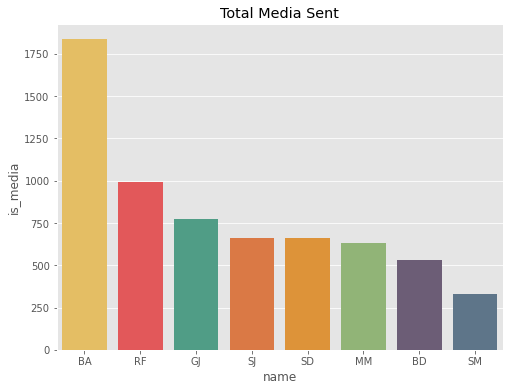

In [14]:
# Plot 3 - Barplot of total media count
plt.figure(figsize = (8, 6))
df['is_media'] = df['msg'].apply(lambda x: 1 if '<Media omitted>' in x else 0)
df.groupby('name').sum().reset_index().sort_values(by = 'is_media', ascending = False)[['name', 'is_media']]
total_media_count = df.groupby('name').sum().reset_index().sort_values(by = 'is_media', ascending = False)[['name', 'is_media']]
sns.barplot(x = 'name', y = 'is_media', data = total_media_count, palette = get_colors_of_certain_order(total_media_count['name']))
plt.title('Total Media Sent')

#plt.savefig('total_media_plot.svg', format = 'svg')
#files.download('total_media_plot.svg')

What's the most used word for each person?

In [15]:
word_dict = dict.fromkeys(df['name'].unique())
for key in word_dict.keys():
  word_dict[key] = {}

for name, msg in zip(df['name'], df['msg']):
  for word in msg.split():
    # If word contains the 'media ommited' message ignore
    if word not in ['<Media', 'omitted>']: 
      if word in word_dict[name]:
        word_dict[name][word] += 1
      else:
        word_dict[name][word] = 1

# Sorting emoji dictionary in descending order of word frequency
for name in df['name'].unique():
  word_dict[name] = {k: v for k, v in sorted(word_dict[name].items(), key = lambda item: item[1], reverse = True)}

grouped_df = df.groupby('name').sum().reset_index()
grouped_df['most_used_words'] = grouped_df['name'].apply(lambda x: word_dict[x])
grouped_df[['name', 'most_used_words']]

,name,most_used_words
0,BA,"{'oh': 2552, 'nooooo': 2480, 'the': 1795, 'i':..."
1,BD,"{'the': 318, 'I': 262, 'is': 261, 'to': 237, '..."
2,GJ,"{'the': 708, 'is': 680, 'I': 585, 'in': 570, '..."
3,MM,"{'..': 1566, 'and': 476, 'to': 414, 'the': 401..."
4,RF,"{'BASIS': 29306, 'the': 1051, 'I': 1003, 'to':..."
5,SD,"{'the': 1008, 'to': 664, 'and': 561, 'a': 509,..."
6,SJ,"{'the': 1485, 'is': 1288, 'a': 1042, 'to': 952..."
7,SM,"{'I': 353, 'Yeah': 294, 'the': 261, 'is': 250,..."


Text(0.5, 1.0, 'Heatmap of month sent and day sent')

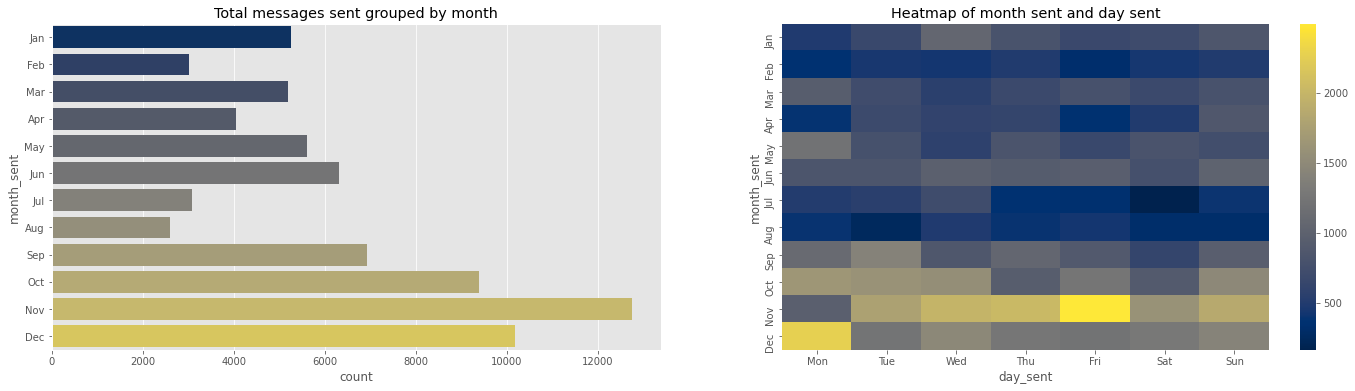

In [16]:
fig, axs = plt.subplots(ncols = 2, figsize = (24, 6))

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
grouped_by_month = df.groupby('month_sent').sum().reset_index().sort_values(by = 'count', ascending = False)
sns.barplot(x = 'count', y = 'month_sent', data = grouped_by_month, order = months, ax = axs[0], palette = sns.color_palette('cividis', 12))
axs[0].set_title('Total messages sent grouped by month')

days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
grouped_by_month_and_day = df.groupby(['month_sent', 'day_sent']).sum().reset_index()[['month_sent', 'day_sent', 'count']]
pt = grouped_by_month_and_day.pivot_table(index = 'month_sent', columns = 'day_sent', values = 'count').reindex(index = months, columns = days)
sns.heatmap(pt, cmap = 'cividis', ax = axs[1])
axs[1].set_title('Heatmap of month sent and day sent')

#plt.savefig('month_activity.svg', format = 'svg')
#files.download('month_activity.svg')

Text(0.5, 1.0, 'Most Active Hours')

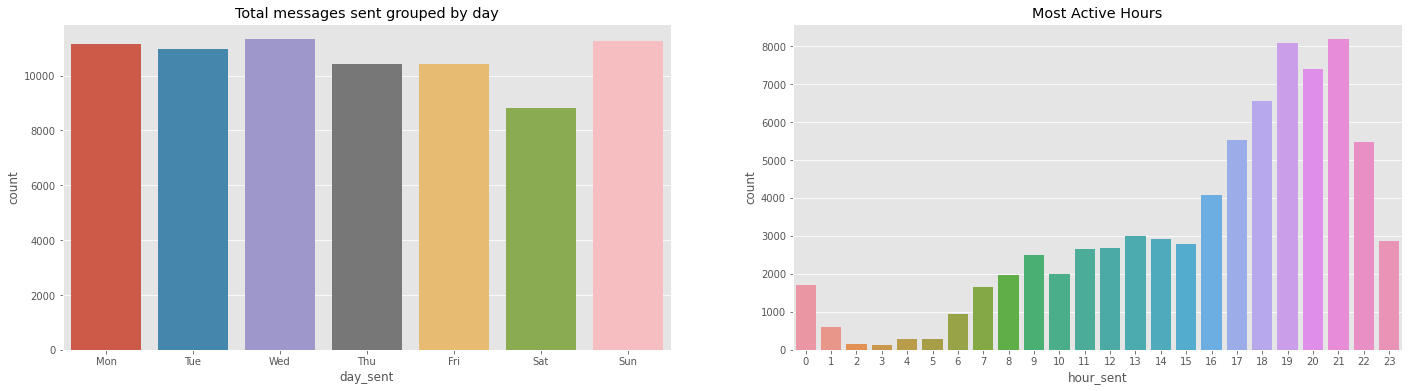

In [17]:
fig, axs = plt.subplots(ncols = 2, figsize = (24, 6))

grouped_by_day = df.groupby('day_sent').sum().reset_index()[['day_sent', 'count']]
sns.barplot(y = 'count', x = 'day_sent', data = grouped_by_day, order = days, ax = axs[0])
axs[0].set_title('Total messages sent grouped by day')

df['hour_sent'] = df['datetime'].apply(lambda x: x.hour)
grouped_by_time = df.groupby('hour_sent').sum().reset_index().sort_values(by = 'count', ascending = False)
sns.barplot(y = 'count', x = 'hour_sent', data = grouped_by_time, ax = axs[1])
axs[1].set_title('Most Active Hours')

#plt.savefig('days_and_times.svg', format = 'svg')
#files.download('days_and_times.svg')

Text(0.5, 1.0, 'Most Active Days')

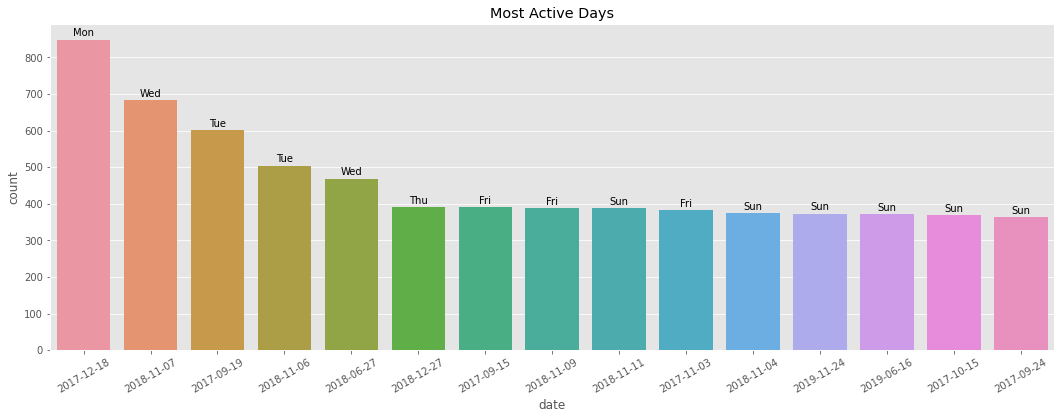

In [18]:
plt.figure(figsize = (18, 6))

grouped_by_date = df.groupby('date').sum().reset_index().sort_values(by = 'count', ascending = False).head(15)
grouped_by_date['day_sent'] = grouped_by_date['date'].apply(lambda x: x.strftime('%a'))
ax = sns.barplot(y = 'count', x = 'date', data = grouped_by_date)

# I spent way too long to get the bar annotations to work properly. Thank you again, StackOverflow.
for bar, label in zip(ax.patches, grouped_by_date['day_sent']):
    x = bar.get_x()
    width = bar.get_width()
    height = bar.get_height()
    ax.text(x + width/2., height + 10, label, ha="center") 

ax.set_xticklabels(ax.get_xticklabels(), rotation = 30)
plt.title('Most Active Days')

#plt.savefig('most_active_days.svg', format = 'svg')
#files.download('most_active_days.svg')

For each person, I'm initializing a dictionary containing all emojis, even ones with 0 occurences. I tried to count only the occuring emojis for each person but I was running into an error where the dictionary didn't contain all occurences of an emoji for a person. I spent hours trying to solve this, and as an ode to the fact that time once lost is lost, I used a more easier but memory-heavy solution. Sacrificing efficiency for utility but hey it's small enough to not cause performance issues so I guess this will do. 

*(I can hear you screaming, software engineers.)*


,name,most_used_emojis
4,RF,"{'👍': 2572, '😂': 942, '🤣': 435, '🏻': 61, '😎': 55}"
7,SM,"{'😂': 1145, '🤣': 1027, '🏻': 140, '😍': 131, '🔥'..."
0,BA,"{'😂': 1146, '🤣': 647, '🏻': 165, '👌': 69, '😑': 57}"
3,MM,"{'🏻': 633, '🤣': 349, '😂': 256, '♂': 221, '👍': ..."
2,GJ,"{'😂': 1059, '😹': 411, '🤣': 383, '😑': 148, '👍':..."
6,SJ,"{'😂': 672, '🤣': 272, '😅': 85, '😭': 60, '👍': 30}"
1,BD,"{'🏻': 207, '🤣': 204, '👌': 101, '🔥': 80, '🙂': 77}"
5,SD,"{'😂': 81, '🏻': 78, '😘': 34, '🙃': 29, '🌚': 28}"


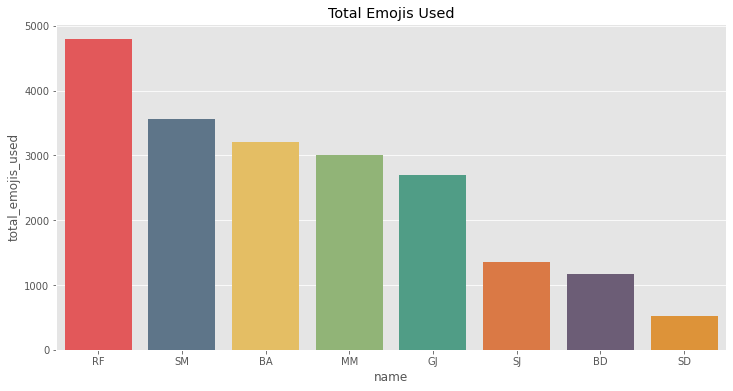

In [19]:
# Filtering out messages that don't contain emojis
df['emojis'] = df['msg'].apply(lambda x: ''.join(c for c in x if c in emoji.UNICODE_EMOJI))
emoji_df = df[df['emojis'].apply(lambda x: True if x else False)]

emoji_dict = dict.fromkeys(df['name'].unique())
for key in emoji_dict.keys():
  emoji_dict[key] = {}
  for emoji_key in emoji.UNICODE_EMOJI.keys():
    emoji_dict[key][emoji_key] = 0

# Counting occurence of each emoji for each person
for name, emojis in zip(emoji_df['name'], emoji_df['emojis']):
  for single_emoji in emojis:
    emoji_dict[name][single_emoji] += 1

# Sorting emoji dictionary in descending order of emoji frequency
for name in df['name'].unique():
  emoji_dict[name] = {k: v for k, v in sorted(emoji_dict[name].items(), key = lambda item: item[1], reverse = True)}

# Using grouped_df, getting top 5 used emojis for each person, and constructing bar plot of overall emoji count for each person
# Following line used to get top 5 used emojis from the sorted emoji dictionary. Thank you StackOverflow.
grouped_df['most_used_emojis'] = grouped_df['name'].apply(lambda x: dict(itertools.islice(emoji_dict[x].items(), 5)))
grouped_df['total_emojis_used'] = grouped_df['name'].apply(lambda x: sum(emoji_dict[x].values()))
grouped_df = grouped_df.sort_values(by = 'total_emojis_used', ascending = False)
plt.figure(figsize = (12, 6))
sns.barplot(x = 'name', y = 'total_emojis_used', data = grouped_df, palette = get_colors_of_certain_order(grouped_df['name']))
plt.title('Total Emojis Used')
grouped_df[['name', 'most_used_emojis']]

#plt.savefig('total_emojis_used.svg', format = 'svg')
#files.download('total_emojis_used.svg')

In [20]:
df[df['name'] == 'RF'].sort_values(by = 'msg_length', ascending = False).iloc[4]

datetime                                    2019-11-08 21:16:00
name                                                         RF
msg            👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍...
date                                                 2019-11-08
day_sent                                                    Fri
month_sent                                                  Nov
year_sent                                                  2019
count                                                         1
msg_length                                                 2561
is_media                                                      0
hour_sent                                                    21
emojis        👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍...
Name: 73953, dtype: object

# Sentiment Analysis

Text(0.5, 1.0, 'Percentage of texts that contain swear words')

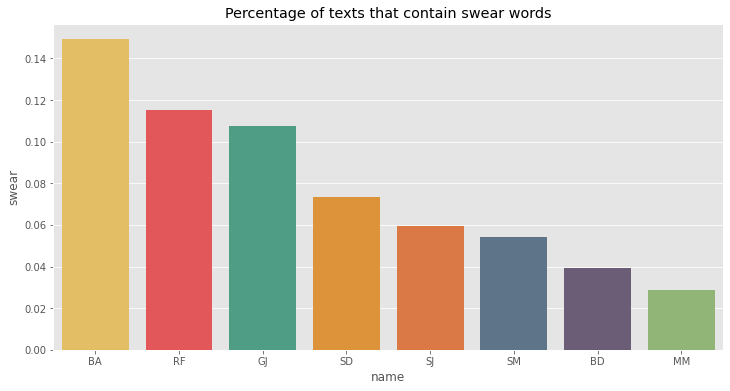

In [21]:
df['swear'] = df['msg'].apply(lambda x: sum(predict([x])))  #sum() because the probability was returned as [n] instead of n
df.head()

plt.figure(figsize = (12, 6))
avg_swear_scores = df.groupby('name').mean().sort_values(by = 'swear', ascending = False)['swear'].reset_index()
sns.barplot(x = 'name', y = 'swear', data = avg_swear_scores, palette = get_colors_of_certain_order(avg_swear_scores['name']))
plt.title('Percentage of texts that contain swear words')

#plt.savefig('swear_plot.svg', format = 'svg')
#files.download('swear_plot.svg')

## VADER (Valence Aware Dictionary and sEntiment Reasoner)

Text(0.5, 1.0, 'Most Active Hours')

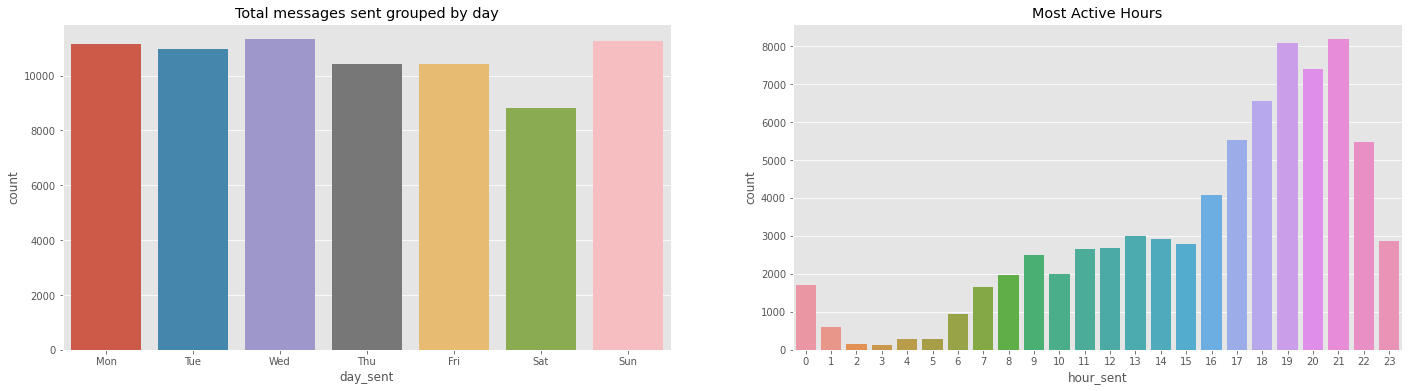

In [22]:
fig, axs = plt.subplots(ncols = 2, figsize = (24, 6))

grouped_by_day = df.groupby('day_sent').sum().reset_index()[['day_sent', 'count']]
sns.barplot(y = 'count', x = 'day_sent', data = grouped_by_day, order = days, ax = axs[0])
axs[0].set_title('Total messages sent grouped by day')

df['hour_sent'] = df['datetime'].apply(lambda x: x.hour)
grouped_by_time = df.groupby('hour_sent').sum().reset_index().sort_values(by = 'count', ascending = False)
sns.barplot(y = 'count', x = 'hour_sent', data = grouped_by_time, ax = axs[1])
axs[1].set_title('Most Active Hours')

#plt.savefig('days_and_times.svg', format = 'svg')
#files.download('days_and_times.svg')

Text(0.5, 1.0, 'Average TextBlob sentiment score')

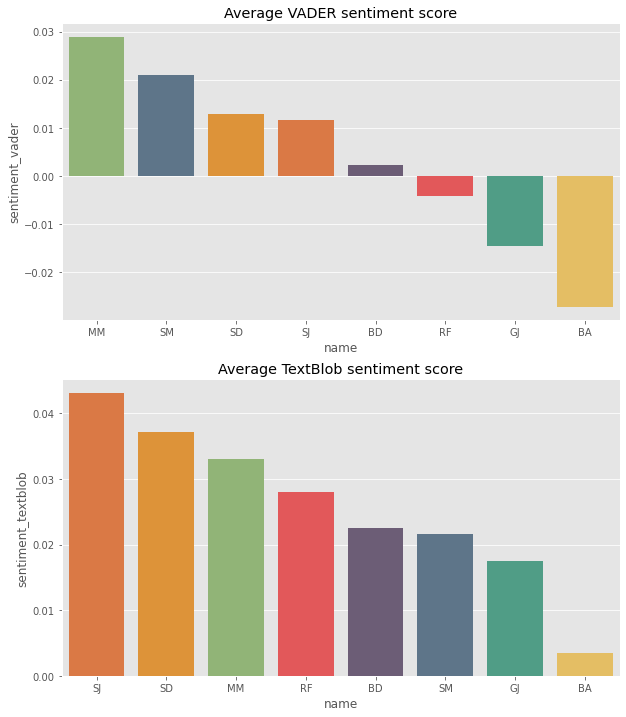

In [23]:
fig, axs = plt.subplots(nrows = 2, figsize = (10, 12))

sid = SentimentIntensityAnalyzer()
df['sentiment_vader'] = df['msg'].apply(lambda x: sid.polarity_scores(x)['compound'])
grouped_by_name = df.groupby('name').mean().reset_index().sort_values(by = 'sentiment_vader', ascending = False)
sns.barplot(x = 'name', y = 'sentiment_vader', data = grouped_by_name, palette = get_colors_of_certain_order(grouped_by_name['name']), ax = axs[0])
axs[0].set_title('Average VADER sentiment score')

df['sentiment_textblob'] = df['msg'].apply(lambda x: TextBlob(x).sentiment.polarity)
grouped_by_name = df.groupby('name').mean().reset_index().sort_values(by = 'sentiment_textblob', ascending = False)
sns.barplot(x = 'name', y = 'sentiment_textblob', data = grouped_by_name, palette = get_colors_of_certain_order(grouped_by_name['name']), ax = axs[1])
axs[1].set_title('Average TextBlob sentiment score')

#plt.savefig('sentiment_plot.svg', format = 'svg')
#files.download('sentiment_plot.svg')

In [24]:
df.sort_values(by = 'sentiment_textblob', ascending = False)[['name', 'msg', 'sentiment_vader', 'sentiment_textblob']].head(20)

,name,msg,sentiment_vader,sentiment_textblob
23466,SJ,All the best then,0.6369,1.0
12697,SJ,Tell best under 5rs,0.6369,1.0
5385,SJ,She's awesome,0.6249,1.0
62734,SD,Which is the best VPN that you can use?,0.6369,1.0
73191,SJ,Awesome,0.6249,1.0
776,SJ,And abu your percentile is awesome,0.6249,1.0
65009,GJ,Happy birthday!,0.6114,1.0
12709,SJ,Awesome,0.6249,1.0
46424,RF,Almost perfect!,0.5717,1.0
20768,RF,Thank you y'all <3,0.6597,1.0
